# Flow control

Suppose we have a link between sender and receiver.
We want to the sender to send as fast as possible to have the fastest transmission rate,
however if the sender is faster than what the receiver can handle,
the messages will be placed onto the receivers buffer.
If this persists, it may lead to buffer overflow or discarded messages.

Thus, **flow control** is the techniques used to prevent the sender from overwhelming the receiver.

Flow control is used in layer 4 (and optionally on layer 2).

There are a few implementations of flow control.

## Stop and wait

1. Source transmit a frame
2. Receiver replies with an acknowledgement (ACK) when it receives it
3. Source will only send the next frame when it receives an ACK
4. Receiver controls the flow by deciding whether to reply with the ACK

### Benefits

Simple

### Drawbacks

Inefficient for large data transfer

## Sliding window

By extension from the stop and wait approach,
we allow multiple frames to be in transit by keeping a window.

Each frame is numbered, and the frame member is send in the frame header.
Receiver has a buffer of size $W$, which means sender can send up to $W$ frames without acknowledgement.

Receiver replies with ACK $n$ (or RR n, _receiver ready_),
to indicate that it received frames up to $n-1$ and is waiting to receive frame $n$.

## Error detection

We need to recognize that the transmission may not be completely reliable.
For the full message to still be transmitted, we need **automatic repeat request** (ARQ).

### Stop and wait ARQ

In stop and wait, when the frame is damaged/lost,
the receiver won't send the ACK.
The sender will then timeout waiting for the ACK, and resend the frame when it happens.

However, it is possible that the ACK is lost too.
If the sender resends the same frame, the receiver would mistake this as the next frame.
Thus, we need to alternate between ACK0 and ACK1,
and receiver will drop the duplicated frame 

### Go back $n$ ARQ

When using sliding window and an error occurs,
receiver discards that frame and all subsequent frames until it is corrected.
They communicate this by sending REJ $i$.
When the sender receives this, they resend frame $i$ onwards.

* Better link utilization than stop and wait
* Better when errors are rare

### Selective reject ARQ

Only rejected frames are retransmitted.

* Much better when errors are common
* Need to arrange frames.

## Analysis

Assumptions:
* transmission time of ACK is negligible
* there won't be errors in the ACK frames (and retransmitted frames that are not the frame in question for _Go back N_)

$P_f$ is the probability that a frame has errors.

$a = \frac{T_p}{T_f} =$ number of frames that can be held on the link

### Stop and wait

It takes a RTT to send a frame and receive an ACK.

Thus it takes $T_f + 2T_p$ to transmit a frame.

The expected number of times a frame needs to be transmitted is $N_r =  \frac{1}{1-P_f}$ (based on [mean of negative binomial distribution](../statistic/probability_distributions.ipynb#Negative-binomial-distribution))

Thus, the utilization rate is $U = \frac{T_f}{N_r T_t} = \frac{1-P_f}{1+2a}$

### Go back N

$$
U =
\begin{cases*}
\frac{1-P_f}{1+2aP_f}  \quad \text{if } W \geq 1 + 2a \\
W \frac{1-P_f}{(1+2a)(1 - P_f + W P_f)} \quad \text{otherwise}
\end{cases*}
$$ 

(Derivation omitted)

### Selective reject

$$
U = 
\begin{cases*}
1-P_f \quad \text{if } W \geq 1 + 2a \\
W \frac{1-P_f}{1+2a} \quad \text{otherwise}\\
\end{cases*}
$$ 

(Derivation omitted)


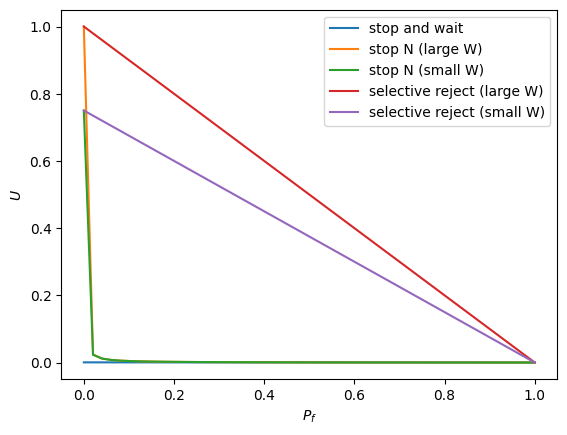

In [1]:
import matplotlib.pyplot as plt
import numpy as np

pfs = np.linspace(0, 1)
a = 1000
boundary = 1 + 2*a
w_lo = boundary - 500

plt.plot(pfs, (1-pfs) / (1+2*a), label="stop and wait")
plt.plot(pfs, (1-pfs) / (1+2*a*pfs), label="stop N (large W)")
plt.plot(pfs, w_lo * (1-pfs) / (1+2*a) / (1 - pfs + w_lo * pfs), label="stop N (small W)")
plt.plot(pfs, 1-pfs, label="selective reject (large W)")
plt.plot(pfs, w_lo * (1-pfs) / (1 + 2 * a), label="selective reject (small W)")

plt.legend()
plt.xlabel("$P_f$")
plt.ylabel("$U$")
plt.show()

From here, we can see that:
* stop and wait has the worst utilization rate
* go back N is severely affected by increasing error rate
* selective reject degrades linearly with error rate